# Initializatinos

In [1]:
!git clone https://github.com/mojtaba-nafez/UNODE.git

Cloning into 'CSI'...
remote: Enumerating objects: 4478, done.
remote: Counting objects: 100% (2893/2893), done.
remote: Compressing objects: 100% (879/879), done.
remote: Total 4478 (delta 2108), reused 2708 (delta 2014), pack-reused 1585
Receiving objects: 100% (4478/4478), 6.95 MiB | 37.47 MiB/s, done.
Resolving deltas: 100% (3284/3284), done.
/kaggle/working/CSI
Branch 'unode_publish' set up to track remote branch 'unode_publish' from 'origin'.
Switched to a new branch 'unode_publish'


In [2]:
%cd UNODE

[Errno 2] No such file or directory: 'CSI'
/kaggle/working/CSI
Already on 'unode_publish'
Your branch is up to date with 'origin/unode_publish'.


In [3]:
%%capture
!kaggle datasets download -d mojtabanafez/resized-224-mvtecad-dataset
!unzip ./resized-224-mvtecad-dataset.zip
!rm -r ./resized-224-mvtecad-dataset.zip

In [ ]:
%%capture
!pip install openai-clip

# Model

In [15]:
import clip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, transform = clip.load("RN50", device=device)

100%|███████████████████████████████████████| 244M/244M [00:07<00:00, 34.7MiB/s]


# Utils

In [16]:
# Extract embeddings
def get_embeddings(model, dataloader, augmentation):
    embeddings = []
    with torch.no_grad():
        for data in dataloader:
            images, _ = data
            images = images.to(device)
            if augmentation:
                images = augmentation(images.squeeze()).unsqueeze(0)
            images = images.to(device)
            out = model.encode_image(images).squeeze(-1).squeeze(-1).cpu()
            embeddings.append(out)
    embeddings = torch.cat(embeddings, 0).numpy()
    return embeddings

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'lime', 'indigo', 'grey', 'navy']

def compute_kl_divergence(pdf_p, pdf_q):
    # Compute KL divergence between two distributions.
    # Add a small number to probability distributions to avoid log(0)
    epsilon = 1e-10
    pdf_p = pdf_p + epsilon
    pdf_q = pdf_q + epsilon
    return entropy(pdf_p, pdf_q)

def process_embeddings_with_tsne_kl(embeddings_list, labels):
    # Concatenate the embeddings
    all_embeddings = np.concatenate(embeddings_list, axis=0)

    # Apply t-SNE to the PCA-reduced combined embeddings
    tsne = TSNE(n_components=2, perplexity=30, n_iter=600)
    all_embeddings_tsne = tsne.fit_transform(all_embeddings)

    # Split back the concatenated t-SNE embeddings into original and augmented
    split_indices = np.cumsum([len(e) for e in embeddings_list])
    tsne_embeddings_list = np.split(all_embeddings_tsne, split_indices[:-1])

    # Calculate KL divergence between original (no augmentation) and each augmentation
    kl_divergences = []
    kde_original = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(tsne_embeddings_list[0])

    # Compute the density of the original embedding space
    pdf_original = np.exp(kde_original.score_samples(tsne_embeddings_list[0]))

    # Visualization setup
    plt.figure(figsize=(10, 10))


    # Scatter plot for original
    plt.scatter(tsne_embeddings_list[0][:, 0], tsne_embeddings_list[0][:, 1], c=colors[0], label=labels[0])

    for i, transformed_embeddings in enumerate(tsne_embeddings_list[1:], start=1):
        # Compute the density of the transformed (augmented) embedding space
        pdf_transformed = np.exp(kde_original.score_samples(transformed_embeddings))

        # Compute KL divergence
        kl_div = compute_kl_divergence(pdf_original, pdf_transformed)
        kl_divergences.append(kl_div)

        # Scatter plot for each augmentation
        plt.scatter(transformed_embeddings[:, 0], transformed_embeddings[:, 1], c=colors[i % len(colors)], label=labels[i])

    plt.legend()
    plt.title("t-SNE embeddings with various augmentations")
    plt.show()

    return kl_divergences


In [18]:
def softmax(x, tau=10):
    """Compute softmax values for each set of scores in x."""
    x = np.array(x)
    e_x = np.exp((x - np.max(x)) / tau)
    return e_x / e_x.sum()

# CIFAR-10

In [85]:
import torch 
from torch.utils.data import DataLoader
from datasets.datasets import get_superclass_list
from train import initialize, prepare_datasets, prepare_dataloaders
from args import parse_args
from datasets.negative_pair_generation import NegativePairGenerator

P = parse_args(True)
cls_list = get_superclass_list(P.dataset)
P.dataset  = 'cifar10' # "mvtecad"
P.image_size = 224 # 224
P.normal_class = 1
P.normal_data_count = 5000
P.ood_dataset = [elem for elem in cls_list if elem not in [P.normal_class]]

train_set, test_set, full_test_set = prepare_datasets(P)
train_loader = DataLoader(train_set, shuffle=True, batch_size=1)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1)

neg_pair_gen = NegativePairGenerator(P)

augmentations = {'identity': None, 'mixup': neg_pair_gen.apply_mixup, 'elastic': neg_pair_gen.apply_elastic, 'rotation': neg_pair_gen.apply_rotation, 'cutout': neg_pair_gen.apply_cutout, 'cutpaste': neg_pair_gen.apply_cutpaste}
augmentations_name = ['identity', 'mixup', 'elastic', 'rotation', 'cutout', 'cutpaste']

Files already downloaded and verified
Files already downloaded and verified
train_set shapes:  torch.Size([3, 224, 224])
test_set shapes:  torch.Size([3, 224, 224])


In [86]:
all_embeddings = []

for aug in augmentations_name:
    print(f"Get {aug} transform embedding ...")
    embeddings = get_embeddings(model, test_loader, augmentations[aug])
    all_embeddings.append(embeddings)

Get identity transform embedding ...
Get mixup transform embedding ...
Get elastic transform embedding ...
Get rotation transform embedding ...
Get cutout transform embedding ...
Get cutpaste transform embedding ...


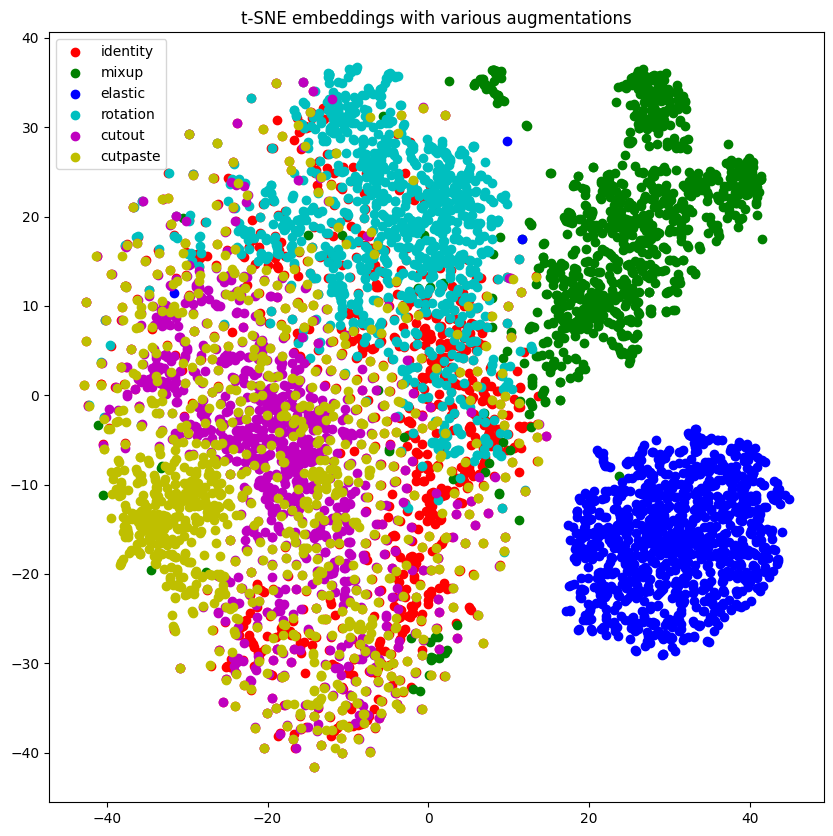

In [87]:
kl_divs = process_embeddings_with_tsne_kl(all_embeddings, augmentations_name)

In [88]:
for kl_value, name in zip(kl_divs, augmentations_name[1:]):
      print(f'KL Value on t-SNE of original v.s {name}: {kl_value:.2f}')

KL Value on t-SNE of original v.s mixup: 11.22
KL Value on t-SNE of original v.s elastic: 3.36
KL Value on t-SNE of original v.s rotation: 4.72
KL Value on t-SNE of original v.s cutout: 7.98
KL Value on t-SNE of original v.s cutpaste: 8.09


In [89]:
p = torch.nn.functional.softmax(torch.tensor(kl_divs), dim=0)
rounded_probs = [round(float(prob)*100, 2) for prob in p]
# Displaying the results
for prob, name in zip(rounded_probs, augmentations_name[1:]):
    print(f'Probability for {name} based on KL Divergence: {prob:.2f} %')

Probability for mixup based on KL Divergence: 92.18 %
Probability for elastic based on KL Divergence: 0.04 %
Probability for rotation based on KL Divergence: 0.14 %
Probability for cutout based on KL Divergence: 3.62 %
Probability for cutpaste based on KL Divergence: 4.03 %


# MVTecAD

In [67]:
import torch 
from torch.utils.data import DataLoader
from datasets.datasets import get_superclass_list
from train import initialize, prepare_datasets, prepare_dataloaders
from args import parse_args
from datasets.negative_pair_generation import NegativePairGenerator

P = parse_args(True)
cls_list = get_superclass_list(P.dataset)
P.dataset  = 'mvtecad' # "mvtecad"
P.image_size = 224 # 224
P.normal_class = 7
P.normal_data_count = -1
P.ood_dataset = [elem for elem in cls_list if elem not in [P.normal_class]]

train_set, test_set, full_test_set = prepare_datasets(P)
train_loader = DataLoader(train_set, shuffle=True, batch_size=1)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1)

neg_pair_gen = NegativePairGenerator(P)

augmentations = {'identity': None, 'mixup': neg_pair_gen.apply_mixup, 'elastic': neg_pair_gen.apply_elastic, 'rotation': neg_pair_gen.apply_rotation, 'cutperm': neg_pair_gen.apply_cutperm, 'cutout': neg_pair_gen.apply_cutout, 'cutpaste': neg_pair_gen.apply_cutpaste}
augmentations_name = ['identity', 'mixup', 'elastic', 'rotation', 'cutperm', 'cutout', 'cutpaste']

category MVTecDataset: bottle
category MVTecDataset: bottle
train_set shapes:  torch.Size([3, 224, 224])
test_set shapes:  torch.Size([3, 224, 224])
len(test_dataset), len(train_dataset) 83 209


In [68]:
all_embeddings = []

for aug in augmentations_name:
    print(f"Get {aug} transform embedding ...")
    embeddings = get_embeddings(model, test_loader, augmentations[aug])
    all_embeddings.append(embeddings)

Get identity transform embedding ...
Get mixup transform embedding ...
Get elastic transform embedding ...
Get rotation transform embedding ...
Get cutperm transform embedding ...
Get cutout transform embedding ...
Get cutpaste transform embedding ...


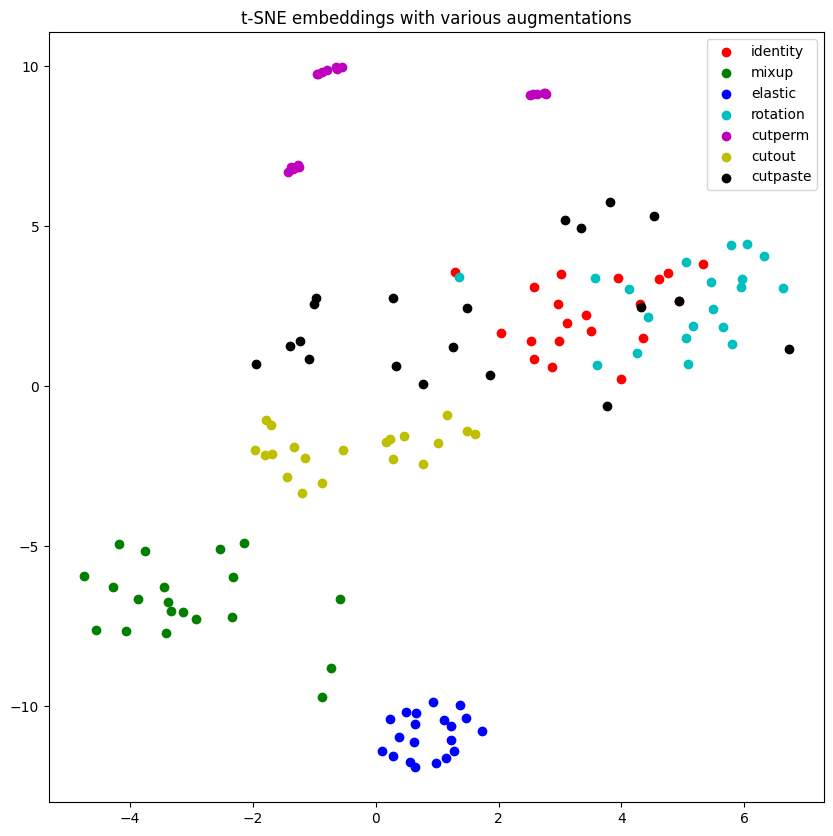

In [69]:
kl_divs = process_embeddings_with_tsne_kl(all_embeddings, augmentations_name)

In [70]:
for kl_value, name in zip(kl_divs, augmentations_name[1:]):
      print(f'KL Value on t-SNE of original v.s {name}: {kl_value:.2f}')

KL Value on t-SNE of original v.s mixup: 0.06
KL Value on t-SNE of original v.s elastic: 0.06
KL Value on t-SNE of original v.s rotation: 0.65
KL Value on t-SNE of original v.s cutperm: 0.06
KL Value on t-SNE of original v.s cutout: 5.83
KL Value on t-SNE of original v.s cutpaste: 7.78


In [71]:
p = torch.nn.functional.softmax(torch.tensor(kl_divs), dim=0)
rounded_probs = [round(float(prob)*100, 2) for prob in p]
# Displaying the results
for prob, name in zip(rounded_probs, augmentations_name[1:]):
    print(f'Probability for {name} based on KL Divergence: {prob:.2f} %')

[0.04, 0.04, 0.07, 0.04, 12.43, 87.39]